# Libraries

In [1]:
import numpy as np
import pandas as pd
import math
# Used to save logs on file
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
# Used for L2 regularization
from tensorflow.keras import regularizers
# Used for dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adamax, RMSprop, Adagrad, Adam
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

from keras import backend as K

import tensorflow as tf


from datetime import datetime

# Used for early stopping
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Handling the dataset

In [3]:
# Read and view TR
# dataset = "cup/ML-CUP20-TR.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TR.csv"

# Column 0:     ID
# Column 1-10:  inputs
# Column 11-12: target_x target_y
train_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
               "input_10", "target_x", "target_y"]
df_train = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=train_names, index_col=0))

# Store the number of training patterns
n_TR_patterns = len(df_train.index)
print(f'N. rows TR: {n_TR_patterns}\n')

# log.write(f'N. rows TR: {n_TR_patterns}\n')

# print(df_train.head())

# Read and view TS
# dataset = "cup/ML-CUP20-TS.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TS.csv"

# Column 0:    ID
# Column 1-10: inputs
test_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
              "input_10"]
df_test = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=test_names, index_col=0))

# Store the number of (blind) testing patterns
n_TS_patterns = len(df_test.index)
print(f'N. rows TS: {n_TS_patterns}\n')

# log.write(f'N. rows TS: {n_TS_patterns}\n')

# print(df_test.head())

N. rows TR: 1524

N. rows TS: 472



#DATA MANIPULATION

In [4]:
# Divide into TR and (internal) TS
attributes = [col for col in df_train.columns if 'input' in col]

# Separating internal TS from the rest of training dataset (ca. 20%)
print("\ndf_train ", len(df_train))  # 1524

df_subset = df_train.sample(200, random_state=100) #modifico la size del blind test set
print("\ndf_subset ", len(df_subset))  # 304
print(df_subset.head())

df_train = df_train.drop(df_subset.index)
print("\ndf_train after removal ", len(df_train))  # 1220

X_train = df_train[attributes].values
y_train = df_train[['target_x', 'target_y']].values

X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

n_features = X_train.shape[1]
print(X_train.shape[0])

print(f'\nN. input features: {n_features}')

# log.write(f'\nN. input features: {n_features}')

# Handle (blind) TS
attributes = [col for col in df_test.columns if 'input' in col]
X_blind_TS = df_test[attributes].values



df_train  1524

df_subset  200
       input_1   input_2   input_3  ...  input_10   target_x   target_y
id                                  ...                                
801   1.155300  0.059795 -0.604900  ...  1.727382  39.929663 -29.595517
720  -0.918605  0.637450  1.347002  ... -0.903759  72.384610 -28.855841
1059 -0.652593  1.394323  0.103282  ... -1.030427  52.796461 -39.445597
189   1.439956 -0.605409 -0.758339  ...  1.819379  40.553341 -30.551312
229   0.915644 -1.250489 -1.028318  ...  0.055362  31.467524 -13.706777

[5 rows x 12 columns]

df_train after removal  1324
1324

N. input features: 10


# Building the network

In [5]:
def mee_keras(y_true, y_pred):
  return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True)))

In [6]:
def r2_keras(y_true, y_pred):
  SS_res = K.sum(K.square(y_true-y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1 - SS_res/(SS_tot + K.epsilon()))

In [7]:
# Construction of the Neural Network
# Units input layer
# units_in = 6
# Units hidden layer
# units_hid = 4


def build_model(neurons=1, dropout_rate=0.0, weight_constraint=0, activation='sigmoid', learn_rate=0.001, momentum=0,
                reg_value=0, optimizer='adam', init_mode='uniform'):
    # Cleanup
    #K.clear_session()
    tf.keras.backend.clear_session()
    # Build the model
    model = Sequential()

    if reg_value != 0:
        # Apply regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_2 = Dense(neurons, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_3 = Dense(2, activation='linear')
    else:
        # No regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation)
        layer_2 = Dense(neurons, activation=activation)
        layer_3 = Dense(2, activation=activation)

    model.add(layer_1)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_2)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_3)

    # Compile the model
    if optimizer == 'SGD':
      # opt = SGD(learning_rate=learn_rate, momentum=momentum)
      # With clipping
      opt = SGD(learning_rate=learn_rate, momentum=momentum, clipnorm=1.0)
    elif optimizer == 'Adamax':
      # opt = Adamax(learning_rate=learn_rate, name="Adamax")
      # With clipping
      opt = Adamax(learning_rate=learn_rate, name="Adamax", clipnorm=1.0)
    elif optimizer == 'RMSprop':
      # With clipping
      opt = RMSprop(learning_rate=learn_rate, rho=0.9, momentum=momentum, 
                    epsilon=1e-07, centered=False, name="RMSprop", clipnorm=1.0)
    elif optimizer == 'Adagrad':
      # With clipping
      opt = Adagrad(learning_rate=learn_rate, initial_accumulator_value=0.1,
                    epsilon=1e-07, name="Adagrad", clipnorm=1.0)
    else: 
      # Adam
      # With clipping
      opt = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-07, amsgrad=False, name="Adam", clipnorm=1.0)
    
    # Metrics: MSE, MEE (manual implementation), R^2 (manual implementation)
    model.compile(loss=MeanSquaredError(),
                  optimizer=opt,
                  # metrics=[tf.keras.metrics.MeanSquaredError()])
                  metrics=[tf.keras.metrics.MeanSquaredError(), mee_keras, 
                           r2_keras]) 

    return model


# Manual initialization

In [8]:
# Construction of the Neural Network
# Units input layer
# units_in = 6
# Units hidden layer
# units_hid = 4


def build_model(neurons=1, dropout_rate=0.0, weight_constraint=0, activation='sigmoid', learn_rate=0.001, momentum=0,
                reg_value=0, optimizer='adam', init_mode='uniform'):
    # Cleanup
    #K.clear_session()
    tf.keras.backend.clear_session()
    # Build the model
    model = Sequential()

    if reg_value != 0:
        # Apply regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_2 = Dense(neurons, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value))
        layer_3 = Dense(2, activation='linear')
    else:
        # No regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation)
        layer_2 = Dense(neurons, activation=activation)
        layer_3 = Dense(2, activation=activation)

    model.add(layer_1)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_2)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model.add(Dropout(dropout_rate, seed=123))

    model.add(layer_3)

    # Compile the model
    if optimizer == 'SGD':
      # opt = SGD(learning_rate=learn_rate, momentum=momentum)
      # With clipping
      opt = SGD(learning_rate=learn_rate, momentum=momentum, clipnorm=1.0)
    elif optimizer == 'Adamax':
      # opt = Adamax(learning_rate=learn_rate, name="Adamax")
      # With clipping
      opt = Adamax(learning_rate=learn_rate, name="Adamax", clipnorm=1.0)
    elif optimizer == 'RMSprop':
      # With clipping
      opt = RMSprop(learning_rate=learn_rate, rho=0.9, momentum=momentum, 
                    epsilon=1e-07, centered=False, name="RMSprop", clipnorm=1.0)
    elif optimizer == 'Adagrad':
      # With clipping
      opt = Adagrad(learning_rate=learn_rate, initial_accumulator_value=0.1,
                    epsilon=1e-07, name="Adagrad", clipnorm=1.0)
    else: 
      # Adam
      # With clipping
      opt = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-07, amsgrad=False, name="Adam", clipnorm=1.0)
    
    # Metrics: MSE, MEE (manual implementation), R^2 (manual implementation)
    model.compile(loss=MeanSquaredError(),
                  optimizer=opt,
                  # metrics=[tf.keras.metrics.MeanSquaredError()])
                  metrics=[tf.keras.metrics.MeanSquaredError(), mee_keras, 
                           r2_keras]) 

    return model


In [9]:
def init_config(units_hid = 10, r = 1/math.sqrt(n_features)):
  config_hid1 = []
  config_hid2 = []
  config_hid3 = []
  # config_hid4 = []
  # config_hid5 = []

  # weights_in = np.random.uniform(-0.2, 0.2, size=(n_features,units_hid))
  weights_in = np.random.uniform(-r, r, size=(n_features,units_hid))
  # bias_in = np.random.uniform(-0.2, 0.2, units_hid)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(units_hid)
  else:
    bias_in = np.random.uniform(-r, r, units_hid)
  config_hid1.append(weights_in)
  config_hid1.append(bias_in)

  # weights_in = np.random.uniform(-0.2, 0.2, size=(n_features,units_hid))
  weights_in = np.random.uniform(-r, r, size=(units_hid,units_hid))
  # bias_in = np.random.uniform(-0.2, 0.2, units_hid)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(units_hid)
  else:
    bias_in = np.random.uniform(-r, r, units_hid)
  config_hid2.append(weights_in)
  config_hid2.append(bias_in)

  # weights_hid = np.random.uniform(-0.3, 0.3, size=(units_hid,1))
  weights_in = np.random.uniform(-r, r, size=(units_hid,2))
  # bias_hid = np.random.uniform(-0.2, 0.2, 1)
  if r == 1/math.sqrt(n_features):
    bias_in = np.zeros(2)
  else:
    bias_in = np.random.uniform(-r, r, 2)
  config_hid3.append(weights_in)
  config_hid3.append(bias_in)

  # return [config_hid1, config_hid2, config_hid3, config_hid4, config_hid5]
  return [config_hid1, config_hid2, config_hid3]
  

In [10]:
early_val_loss = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=100,
    mode="min",
    restore_best_weights=True,
)

early_val_accuracy = EarlyStopping(
    monitor="val_r2_keras",
    patience=100,
    mode="max",
    restore_best_weights=True,
)


In [11]:
# Current best model
n_neurons = 250
model = build_model(neurons=n_neurons, dropout_rate=0.0, weight_constraint=1, activation='tanh', learn_rate=0.0003, momentum=0.0, reg_value=0.01, optimizer='Adamax', init_mode='he_uniform')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               2750      
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
Total params: 66,002
Trainable params: 66,002
Non-trainable params: 0
_________________________________________________________________


#CROSS VALIDATION

In [12]:
from sklearn.model_selection import KFold

num_folds = 20
batch_size=50

min_mee = 100

# Define per-fold score containers
mse_per_fold = []
mee_per_fold = []
r2_per_fold = []
loss_per_fold = []

val_mse_per_fold = []
val_mee_per_fold = []
val_r2_per_fold = []
val_loss_per_fold = []


list_of_history = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X_train, y_train):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size, validation_split=0.33,
              epochs=500, 
              callbacks=[early_val_accuracy, early_val_loss] 
              )

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)

  #compare mee value on fold test set to select the best submodel
  if min_mee > scores[2]:
    min_mee = scores[2]
    submodel = model
    best_fold = fold_no
  
  loss_per_fold.append(scores[0])
  mse_per_fold.append(scores[1])
  mee_per_fold.append(scores[2])
  r2_per_fold.append(scores[3])

  list_of_history.append(history)

  # Increase fold number
  fold_no = fold_no + 1

Output streaming troncato alle ultime 5000 righe.
17/17 [==============================] - 0s 7ms/step - loss: 12.5107 - mean_squared_error: 7.8371 - mee_keras: 3.1546 - r2_keras: 0.9952 - val_loss: 13.1926 - val_mean_squared_error: 8.5225 - val_mee_keras: 3.2448 - val_r2_keras: 0.9950
Epoch 130/500
17/17 [==============================] - 0s 8ms/step - loss: 12.4695 - mean_squared_error: 7.8025 - mee_keras: 3.1435 - r2_keras: 0.9952 - val_loss: 13.1787 - val_mean_squared_error: 8.5157 - val_mee_keras: 3.2492 - val_r2_keras: 0.9950
Epoch 131/500
17/17 [==============================] - 0s 7ms/step - loss: 12.4345 - mean_squared_error: 7.7745 - mee_keras: 3.1478 - r2_keras: 0.9952 - val_loss: 13.2337 - val_mean_squared_error: 8.5769 - val_mee_keras: 3.2615 - val_r2_keras: 0.9950
Epoch 132/500
17/17 [==============================] - 0s 8ms/step - loss: 12.4046 - mean_squared_error: 7.7505 - mee_keras: 3.1446 - r2_keras: 0.9952 - val_loss: 13.1663 - val_mean_squared_error: 8.5161 - val_m

In [13]:
print('Best fold model:', best_fold)
print('Min MEE reached:', min_mee)


Best fold model: 14
Min MEE reached: 1.8397440910339355


In [14]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold - test set')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]} - MEE: {mee_per_fold[i]} - R2: {r2_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(mse_per_fold)}')
print(f'> MEE: {np.mean(mee_per_fold)}')
print(f'> R2: {np.mean(r2_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold - test set
------------------------------------------------------------------------
> Fold 1 - Loss: 10.832283973693848 - MSE: 7.561642169952393 - MEE: 3.8406894207000732 - R2: 0.9914670586585999
------------------------------------------------------------------------
> Fold 2 - Loss: 11.359734535217285 - MSE: 8.1155424118042 - MEE: 3.2376911640167236 - R2: 0.995466947555542
------------------------------------------------------------------------
> Fold 3 - Loss: 8.716416358947754 - MSE: 5.5627760887146 - MEE: 3.6810505390167236 - R2: 0.9887543320655823
------------------------------------------------------------------------
> Fold 4 - Loss: 11.412205696105957 - MSE: 8.260871887207031 - MEE: 3.8173019886016846 - R2: 0.9926440119743347
------------------------------------------------------------------------
> Fold 5 - Loss: 9.561577796936035 - MSE: 6.412336826324463 - MEE: 2.6223161220550537 - R2: 0.

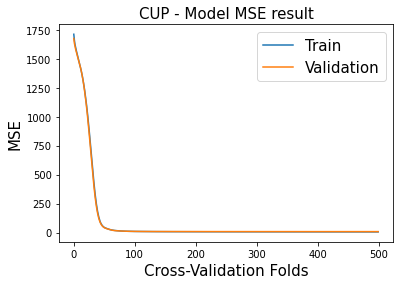

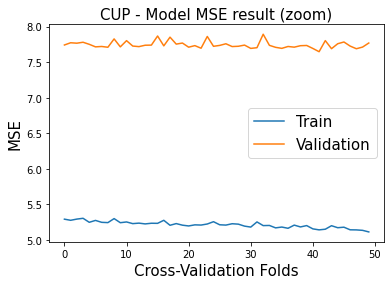

--- --- --- --- --- --- --- --- --- --- --- --- ---


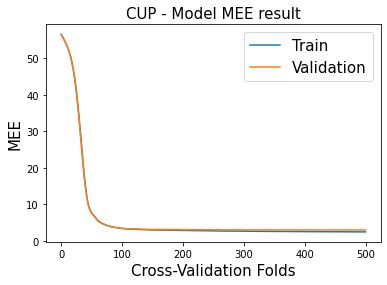

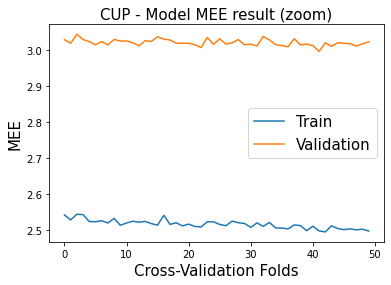

--- --- --- --- --- --- --- --- --- --- --- --- ---


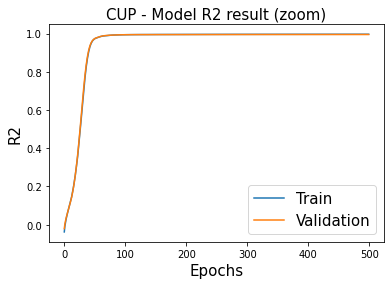

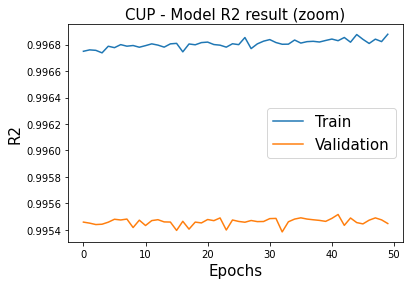

In [15]:
#plot of the first fold, that shows better the learning curve

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

plt.title('CUP - Model MSE result', fontsize=15)
plt.plot(list_of_history[0].history['mean_squared_error'], label='Train')
plt.plot(list_of_history[0].history['val_mean_squared_error'], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

#get a zoom of last 50 elements
plt.title('CUP - Model MSE result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['mean_squared_error'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_mean_squared_error'][-50:], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('--- --- --- --- --- --- --- --- --- --- --- --- ---')

plt.title('CUP - Model MEE result', fontsize=15)
plt.plot(list_of_history[0].history['mee_keras'], label='Train')
plt.plot(list_of_history[0].history['val_mee_keras'], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

#get a zoom of last 50 elements
plt.title('CUP - Model MEE result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['mee_keras'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_mee_keras'][-50:], label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('--- --- --- --- --- --- --- --- --- --- --- --- ---')

#plot R2 value for each fold
plt.title('CUP - Model R2 result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['r2_keras'], label='Train')
plt.plot(list_of_history[0].history['val_r2_keras'], label='Validation')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('R2', fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.title('CUP - Model R2 result (zoom)', fontsize=15)
plt.plot(list_of_history[0].history['r2_keras'][-50:], label='Train')
plt.plot(list_of_history[0].history['val_r2_keras'][-50:], label='Validation')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('R2', fontsize=15)
plt.legend(fontsize=15)
plt.show()


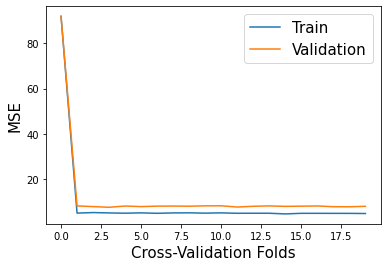

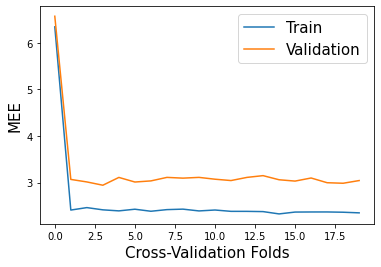

In [16]:
#plots of average values in CV

mean_val_loss = []
mean_train_loss = []

mean_val_mee = []
mean_train_mee = []

for i in range (num_folds):
  mean_val_loss.append(np.mean(list_of_history[i].history['val_mean_squared_error']))
  mean_train_loss.append(np.mean(list_of_history[i].history['mean_squared_error']))

  mean_val_mee.append(np.mean(list_of_history[i].history['val_mee_keras']))
  mean_train_mee.append(np.mean(list_of_history[i].history['mee_keras']))


plt.plot(mean_train_loss, label='Train')
plt.plot(mean_val_loss, label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.plot(mean_train_mee, label='Train')
plt.plot(mean_val_mee, label='Validation')
plt.xlabel('Cross-Validation Folds', fontsize=15)
plt.ylabel('MEE', fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Final testing

In [17]:
early_val_loss_test = EarlyStopping(
    monitor="val_loss",
    patience=150,
    min_delta=0.1,
    mode="min",
    restore_best_weights=True,
)

In [18]:
#retrain the best submodel using entire training set

history = submodel.fit(X_train, y_train, validation_split=0.10, batch_size=batch_size, epochs=30000, callbacks=[early_val_loss_test])

Epoch 1/30000
24/24 [==============================] - 0s 11ms/step - loss: 8.3687 - mean_squared_error: 5.3771 - mee_keras: 2.5416 - r2_keras: 0.9967 - val_loss: 11.5221 - val_mean_squared_error: 8.5327 - val_mee_keras: 3.2100 - val_r2_keras: 0.9947
Epoch 2/30000
24/24 [==============================] - 0s 8ms/step - loss: 8.3549 - mean_squared_error: 5.3656 - mee_keras: 2.5423 - r2_keras: 0.9967 - val_loss: 11.5443 - val_mean_squared_error: 8.5568 - val_mee_keras: 3.2083 - val_r2_keras: 0.9947
Epoch 3/30000
24/24 [==============================] - 0s 8ms/step - loss: 8.3247 - mean_squared_error: 5.3377 - mee_keras: 2.5297 - r2_keras: 0.9968 - val_loss: 11.3716 - val_mean_squared_error: 8.3854 - val_mee_keras: 3.1661 - val_r2_keras: 0.9948
Epoch 4/30000
24/24 [==============================] - 0s 9ms/step - loss: 8.2966 - mean_squared_error: 5.3118 - mee_keras: 2.5178 - r2_keras: 0.9968 - val_loss: 11.5177 - val_mean_squared_error: 8.5346 - val_mee_keras: 3.1904 - val_r2_keras: 0.9948

In [19]:
# Testing model performance on internal TS
X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

TS_results = submodel.evaluate(X_test, y_test, verbose=1)

print('\n---------- Internal TS results ----------')
print(f'Loss: {TS_results[0]} - Metrics - MSE: {TS_results[1]} - MEE: {TS_results[2]} - R2: {TS_results[3]}\n\n\n')

7/7 [==============================] - 0s 3ms/step - loss: 9.1089 - mean_squared_error: 6.3497 - mee_keras: 2.8985 - r2_keras: 0.9962

---------- Internal TS results ----------
Loss: 9.108949661254883 - Metrics - MSE: 6.349700927734375 - MEE: 2.898529052734375 - R2: 0.9962311387062073





# Writing results of the blind test

In [20]:
# Prediction of values on blind TS
# predictions = L2_model.predict(df_test.values, verbose=0) -> For large scale inputs
predictions = model(df_test.values).numpy()
predictions

array([[ 42.63751  , -33.146816 ],
       [ 67.81675  , -32.608547 ],
       [ 77.18464  , -26.926985 ],
       [ 33.872967 , -18.294355 ],
       [ 66.2466   , -33.660828 ],
       [ 51.468395 , -40.608162 ],
       [ 53.280514 , -39.930973 ],
       [ 51.76495  , -40.689007 ],
       [ 37.222073 , -24.609827 ],
       [ 75.147316 , -28.205286 ],
       [ 30.985394 , -11.826254 ],
       [ 35.840954 , -22.715982 ],
       [ 29.093475 ,  -8.091544 ],
       [ 46.930065 , -41.365578 ],
       [ 72.50671  , -29.514433 ],
       [ 44.60301  , -36.621    ],
       [ 62.62304  , -35.553547 ],
       [ 39.329014 , -28.789988 ],
       [ 76.097046 , -26.14565  ],
       [ 29.787077 , -11.077796 ],
       [ 76.05143  , -28.013079 ],
       [ 46.176517 , -40.848568 ],
       [ 41.49016  , -30.906311 ],
       [ 39.41482  , -28.820852 ],
       [ 75.46603  , -28.310518 ],
       [ 59.44128  , -38.338604 ],
       [ 72.72842  , -30.132381 ],
       [ 30.62448  , -11.07888  ],
       [ 75.75239  ,

In [21]:
df_test_results = pd.DataFrame(predictions, df_test.index)
#df_test_results.to_csv(path_or_buf="/content/drive/My Drive/Machine Learning Project/CUP/broken_brain_ML-CUP20-TS.csv", 
                       sep=',', header=False, index=True, index_label=df_test.index)

IndentationError: ignored